# Watson OpenScale SHAP Tree metric for regression model as Spark Job

The notebook will train House Price regression model using CatBoost, generate local and global explanations using SHAP tree explainer in spark job in IBM Analytics Engine/Spark Cluster and data residing in DB2/Hive and provide insights into model behaviour.

### Contents
- [Setup](#Setup)
- [Model building and evaluation](#model)
- [OpenScale configuration](#openscale)
- [Compute SHAP explanations](#shap)
- [Visualize the explanations](#visualize)

**Note:** This notebook requires service credentials of Watson OpenScale.

## Setup

### Package Installation

In [ ]:
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade ibm-metrics-plugin --no-cache | tail -n 1
!pip install matplotlib==3.2.2
!pip install catboost

**Action: Restart the kernel!**

### Configure Credentials

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Provide your IBM Watson OpenScale credentials in the following cell:

In [10]:
WOS_CREDENTIALS = {
    "url": "<cluster_url>",
    "username": "",
    "password": "",
    "instance_id": "<service instance id>"
}

### Provide Spark Connection Details

1. If your job is going to run on Spark cluster as part of an IBM Analytics Engine instance on IBM Cloud Pak for Data, enter the following details:
- **IAE_SPARK_DISPLAY_NAME**: Display Name of the Spark instance in IBM Analytics Engine
- **IAE_SPARK_JOBS_ENDPOINT**: Spark Jobs Endpoint for IBM Analytics Engine
- **IBM_CPD_VOLUME**: IBM Cloud Pak for Data storage volume name
- **IBM_CPD_USERNAME**: IBM Cloud Pak for Data username
- **IBM_CPD_APIKEY**: IBM Cloud Pak for Data API key

2. If your job is going to run on Spark Cluster as part of a Remote Hadoop Ecosystem, enter the following details:
- **SPARK_MANAGER_ENDPOINT**: Endpoint URL where the Spark Manager Application is running
- **SPARK_MANAGER_USERNAME**: Username to connect to Spark Manager Application
- **SPARK_MANAGER_PASSWORD**: Password to connect to Spark Manager Application

**Credentials Block for Spark in IAE**

In [11]:
from ibm_wos_utils.joblib.utils.constants import SparkType

IAE_SPARK_DISPLAY_NAME = "<Display Name of the Spark instance in IBM Analytics Engine>"
IAE_SPARK_JOBS_ENDPOINT = "<Spark Jobs Endpoint for IBM Analytics Engine>"
IBM_CPD_VOLUME = "<IBM Cloud Pak for Data storage volume name>"
IBM_CPD_USERNAME = "<IBM Cloud Pak for Data username>"
IBM_CPD_APIKEY = "<IBM Cloud Pak for Data API key>"

# Credentials Block for Spark in IAE
credentials = {
    "connection": {
        "display_name": IAE_SPARK_DISPLAY_NAME,
        "endpoint": IAE_SPARK_JOBS_ENDPOINT,
        "location_type": SparkType.IAE_SPARK.value,
        "volume": IBM_CPD_VOLUME
    },
    "credentials": {
        "username": IBM_CPD_USERNAME,
        "apikey": IBM_CPD_APIKEY
    }
}

**Credentials Block for Spark in Remote Hadoop Ecosystem**

In [1]:
from ibm_wos_utils.joblib.utils.constants import SparkType

SPARK_MANAGER_ENDPOINT = "<Endpoint URL where Spark Manager Application is running>"
SPARK_MANAGER_USERNAME = "<Username to connect to Spark Manager Application>"
SPARK_MANAGER_PASSWORD = "<Password to connect to Spark Manager Application>"

# Credentials Block for Spark in Remote Hadoop Ecosystem
credentials = {
    "connection": {
        "endpoint": SPARK_MANAGER_ENDPOINT,
        "location_type": SparkType.REMOTE_SPARK.value
    },
    "credentials": {
        "username": SPARK_MANAGER_USERNAME,
        "password": SPARK_MANAGER_PASSWORD
    }
}

### Provide Spark Resource Settings. [Optional]
Configure how much of your Spark Cluster resources can this job consume.

In [12]:
"""
spark_settings = {
    # max_num_executors: Maximum Number of executors to launch for this session
    "max_num_executors": "2",
    
    # min_executors: Minimum Number of executors to launch for this session
    "min_executors": "1",
    
    # executor_cores: Number of cores to use for each executor
    "executor_cores": "2",
    
    # executor_memory: Amount of memory (in GBs) to use per executor process
    "executor_memory": "2",
    
    # driver_cores: Number of cores to use for the driver process
    "driver_cores": "2",
    
    # driver_memory: Amount of memory (in GBs) to use for the driver process 
    "driver_memory": "1"
}
"""

spark_settings = None

### Provide Additional Spark Settings [Optional]
Any other Spark property that can be set via SparkConf, provide them in the next cell. These properties are sent to the Spark cluster verbatim. Leave the variable conf to None or {} if no additional property is required.

[A list of available properties for Spark 2.4.6](https://spark.apache.org/docs/2.4.6/configuration.html#available-properties)

In [13]:
"""
conf = {
    "spark.yarn.maxAppAttempts": 1
}

"""

conf = None

### Generate DDL for creating Explain results table [Optional]
Generate the DDL for creating Explain results table for storing the local explanations. This is an optional step. If the explan results table is not created and specified in the configuration, then only the shap global explanation would be generated and returned in the response

**Generate DDL for creating table in DB2**

In [ ]:
from ibm_metrics_plugin.common.utils.ddl_utils_db2 import generate_explanations_table_ddl

EXPLAINABILITY_SCHEMA_NAME = None

if EXPLAINABILITY_SCHEMA_NAME is not None:
    generate_explanations_table_ddl(schema_name=EXPLAINABILITY_SCHEMA_NAME)

**Generate DDL for creating table in Hive**

In [ ]:
from ibm_metrics_plugin.common.utils.ddl_utils_hive import generate_explanations_table_ddl

EXPLAINABILITY_DATABASE_NAME = None

# Path to the Explanations table Data in HDFS. If not provided hive will determine automatically.
path_to_hdfs_directory = ""

if EXPLAINABILITY_DATABASE_NAME is not None:
    print(generate_explanations_table_ddl(database_name=EXPLAINABILITY_DATABASE_NAME, path_to_hdfs_directory=path_to_hdfs_directory))

### Provide Storage Inputs

1. If the data is present in DB2. Enter DB2 Storage details.

- **JDBC_HOST**: Hostname of the JDBC Connection
- **JDBC_PORT**: Port of the JDBC Connection
- **JDBC_USE_SSL**: Boolean Flag to indicate whether to use SSL while connecting.
- **JDBC_SSL_CERTIFICATE**: SSL Certificate [Base64 encoded string] of the JDBC Connection. Ignored if JDBC_USE_SSL is False.
- **JDBC_DRIVER**: Optional. Class name of the JDBC driver to use to connect e.g. for DB2 use com.ibm.db2.jcc.DB2Driver
- **JDBC_USERNAME**: Username of the JDBC Connection
- **JDBC_PASSWORD**: Password of the JDBC Connection
- **JDBC_DATABASE_NAME**: Name of the JDBC Database to use to connect.
- **TRAINING_SCHEMA_NAME**: Name of the JDBC Schema that has training table.
- **TRAINING_TABLE_NAME**: Name of the JDBC Table that has the scored training data.
- **EXPLAINABILITY_SCHEMA_NAME**: Name of the JDBC Schema that has explainability tables.
- **EXPLAINABILITY_RESULT_TABLE_NAME**: Name of the JDBC Table where the explanations have to be stored.

2. If the data is present in Hive. Enter Hive details.

- **HIVE_METASTORE_URI**: Thrift URI for Hive Metastore to connect to
- **TRAINING_DATABASE_NAME**: Name of the Database in Hive that has training table/view
- **TRAINING_TABLE_NAME**: Name of the Table in Hive that has the scored training data.
- **EXPLAINABILITY_DATABASE_NAME**: Name of the Database in Hive that has explainability tables
- **EXPLAINABILITY_RESULT_TABLE_NAME**: Name of the Table in Hive where the explanations have to be stored.

**Storage details for DB2**

In [7]:
JDBC_HOST = "<Hostname of the JDBC Connection>"
JDBC_PORT = "<Port of the JDBC Connection>"
JDBC_USE_SSL = "<Boolean Flag to indicate whether to use SSL while connecting.>"
JDBC_SSL_CERTIFICATE = "<SSL Certificate [Base64 encoded string] of the JDBC Connection. Ignored if JDBC_USE_SSL is False.>"
JDBC_DRIVER = "<Optional. Class name of the JDBC driver to use to connect e.g. for DB2 use com.ibm.db2.jcc.DB2Driver>"
JDBC_USERNAME = "<Username of the JDBC Connection>"
JDBC_PASSWORD = "<Password of the JDBC Connection>"

JDBC_DATABASE_NAME = "<Name of the JDBC Database to use to connect.>"
TRAINING_SCHEMA_NAME = "<Name of the JDBC Schema that has training table.>"
TRAINING_TABLE_NAME = "<Name of the JDBC Table that has the scored training data.>"

# Specifying explainability result table is optional. If not provided only the SHAP global explanation will be returned.
EXPLAINABILITY_SCHEMA_NAME = "<Name of the JDBC Schema that has explanation table.>"
EXPLAINABILITY_RESULT_TABLE_NAME = "<Name of the JDBC Table where the explanations have to be stored.>"

In [8]:
jdbc_url = "jdbc:db2://{}:{}/{}".format(JDBC_HOST, JDBC_PORT, JDBC_DATABASE_NAME)

storage_details = {
    "type": "jdbc",
    "connection": {
        "jdbc_driver": JDBC_DRIVER,
        "jdbc_url": jdbc_url,
        "use_ssl": JDBC_USE_SSL,
        "certificate": JDBC_SSL_CERTIFICATE,
        "location_type": "jdbc"
    },
    "credentials":{
        "username": JDBC_USERNAME,
        "password": JDBC_PASSWORD,
    }
}

tables = [
    {
        "database": JDBC_DATABASE_NAME,
        "schema": TRAINING_SCHEMA_NAME,
        "table": TRAINING_TABLE_NAME,
        "type": "training",
        "parameters": {
            "partition_column" : None
        }
    }
]

if EXPLAINABILITY_SCHEMA_NAME is not None and EXPLAINABILITY_RESULT_TABLE_NAME is not None:
    tables.append({
        "database": JDBC_DATABASE_NAME,
        "schema": EXPLAINABILITY_SCHEMA_NAME,
        "table": EXPLAINABILITY_RESULT_TABLE_NAME,
        "type": "explain_results"
    })

**Storage details for Hive**

In [42]:
HIVE_METASTORE_URI = "<Thrift URI for Hive Metastore to connect to>"
TRAINING_DATABASE_NAME = "<Name of the Database in Hive that has training table/view>"
TRAINING_TABLE_NAME = "<Name of the Table in Hive that has the scored training data>"

# Specifying explanation table is optional. If not provided only the SHAP global explanation will be returned.
EXPLAINABILITY_DATABASE_NAME = "<Name of the Database in Hive that has explainability tables.>"
EXPLAINABILITY_RESULT_TABLE_NAME = "<Name of the Table in Hive where the explanations have to be stored.>"

In [43]:
storage_details = {
    "type": "hive",
    "connection": {
        "metastore_url": HIVE_METASTORE_URI,
    }
}

tables = [
    {
        "database": TRAINING_DATABASE_NAME,
        "table": TRAINING_TABLE_NAME,
        "type": "training"
    }
]

if EXPLAINABILITY_DATABASE_NAME is not None and EXPLAINABILITY_RESULT_TABLE_NAME is not None:
    tables.append({
        "database": EXPLAINABILITY_DATABASE_NAME,
        "table": EXPLAINABILITY_RESULT_TABLE_NAME,
        "type": "explain_results"
    })

## Model building and evaluation <a name="model"></a>

In this section you will learn how to train regression model using XGBoost, run prediction and evaluate its output.

### Load the training data from github

In [ ]:
!rm house_price_regression.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/house_price/house_price_regression.csv

In [2]:
import pandas as pd
import numpy as np
data_df = pd.read_csv("house_price_regression.csv")

### Explore data

In [3]:
data_df.head()

,Id,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,1,60,7,5,2003,2003,196.0,706,0,150,...,61,0,0,0,0,0,2,2008,Normal,208500
1,2,20,6,8,1976,1976,0.0,978,0,284,...,0,0,0,0,0,0,5,2007,Normal,181500
2,3,60,7,5,2001,2002,162.0,486,0,434,...,42,0,0,0,0,0,9,2008,Normal,223500
3,4,70,7,5,1915,1970,0.0,216,0,540,...,35,272,0,0,0,0,2,2006,Abnorml,140000
4,5,60,8,5,2000,2000,350.0,655,0,490,...,84,0,0,0,0,0,12,2008,Normal,250000


In [4]:
print("Columns: ", list(data_df.columns))
print("Number of columns: ", len(data_df.columns))

Columns:  ['Id', 'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleCondition', 'SalePrice']
Number of columns:  39


### Create a model

In this section you will learn how to:

- Prepare data for training a model
- Create machine learning pipeline
- Train a model
- Evaluate a model

#### Import required libraries

In [5]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

#### Splitting the data into train and test

In [6]:
data_df.dropna(axis=0, inplace=True)
label = data_df.SalePrice
feature_data = data_df.drop(["Id","SalePrice"], axis=1).select_dtypes(exclude=["object"])
feature_data.columns = map(str.lower, feature_data.columns)
X_train, X_test, y_train, y_test = train_test_split(feature_data, label.values, test_size=0.25, random_state=321)

#### Train a model

In [7]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_train, y_train, verbose=False, plot=False)

#### Evaluate the model

In [8]:
predictions = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 16449.17123975315


#### Store the model

In [9]:
model.save_model("house_price.model")

## Openscale Configuration <a name="openscale"></a>

Import the necessary libraries and set up OpenScale Python client.

In [ ]:
from ibm_watson_openscale import APIClient as OpenScaleAPIClient
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator

authenticator = CloudPakForDataAuthenticator(
    url=WOS_CREDENTIALS["url"],
    username=WOS_CREDENTIALS["username"],
    password=WOS_CREDENTIALS["password"],
    disable_ssl_verification=True
)

client = OpenScaleAPIClient(
    service_url=WOS_CREDENTIALS["url"],
    service_instance_id=WOS_CREDENTIALS["instance_id"],
    authenticator=authenticator
)

client.version

## Compute SHAP explanations <a name="shap"></a>

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. See [paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for technical details of the algorithm.

The Shapley value is the average marginal contribution of a feature value across all possible feature coalitions.

SHAP assigns each feature an importance value for a particular prediction which is called SHAP value. The SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

### Prepare input to compute SHAP explanations

#### Create the model python class file with model attribute

SHAP Tree explainer needs access to the model object.
The Model class should accept the model file path in the constructor and load the model in "model" attribute in the class

Below is a sample implementation of model class file for house price regression model.

In [17]:
with open("house_price_model.py", "w") as f:
    f.write("from catboost import CatBoostRegressor\n\n" +
            "class Model():\n\n" +
            "   def __init__(self, model_file_path):\n" +
            "       self.model = CatBoostRegressor()\n" +
            "       self.model.load_model(model_file_path)\n\n")

#### Create configuration for computing the SHAP metric

Set the below properties in the configuration

- **problem_type** : The model problem type. Possible values are 'binary', 'multiclass', 'regression'
- **input_data_type**: The input data type. Supported value is 'structured'
- **feature_columns**: The list of feature columns
- **categorical_columns**: The list of categorical columns
- **record_id** [Optional]: The name of record id column in training data
- **explainability**: The expainability metrics configuration

Mandatory parameters for shap kernel metric
- **algorithm**: The name of algorithm to execute. Possible values are **kernel**, **tree**.
- **model_class**: The name of the python model class file to be loaded in the spark job for scoring
- **model_file**: The name of the model binary file which will be used by the python model class. The path of this file will be passed in the constructor of the Model class

Optional parameters for shap kernel metric

- **result_sample_size**: The number of local explanations to be returned after the job execution. These explanations could be used for plotting. By default a random sample of 1000 explanations will be returned.
- **explanation_types**: The list of explanation types to be generated. Supported values are **global**, **local**. By default both the local and global explanations are generated. Default value is **["global", "local"]**
- **aggregation_methods**: The list of aggregation methods used to combine the shap values of all the datapoints to get the global explanation. Supported values are **mean_abs**(mean of absolute shap values), **max_abs**(max od absolute shap values), **mean_sq**(mean of squares of shap values). Default value is **["mean_abs"]**

In [44]:
from ibm_metrics_plugin.common.utils.constants import ExplainabilityMetricType, ProblemType, InputDataType, MetricGroupType
from ibm_metrics_plugin.metrics.explainability.entity.constants import ShapAlgorithm, ShapAggregationMethod, ExplanationType

metrics_config={
        "problem_type": ProblemType.REGRESSION.value,
        "input_data_type": InputDataType.STRUCTURED.value,
        "feature_columns": list(feature_data.columns),
        "categorical_columns": [],
        # "record_id": "record_id",
        MetricGroupType.EXPLAINABILITY.value : {
            "metrics_configuration": {
                ExplainabilityMetricType.SHAP.value : {
                    "algorithm": ShapAlgorithm.TREE.value,
                    "aggregation_methods": [ShapAggregationMethod.MEAN_ABS.value, ShapAggregationMethod.MAX_ABS.value, ShapAggregationMethod.MEAN_SQ.value],
                    "result_sample_size":100,
                    "model_class": "house_price_model.py",
                    "model_file": "house_price.model"
                    # "explanation_types": [ExplanationType.GLOBAL.value]
                }
            }
        }
    }

#### Create the job parameters

In [45]:
job_params = {
        "spark_settings": spark_settings,
        "arguments": {
            "storage": storage_details,
            "tables": tables,
            "metric_configuration": metrics_config,
        },
        "dependency_zip": [],
        "conf": conf
}

### Compute explanations

Compute the explanations for the test data

In [ ]:
response = client.ai_metrics.compute_metrics_as_job(credentials,
                                                    job_params,
                                                    data_file_list=["house_price_model.py","house_price.model"])


In [47]:
metrics_result=client.ai_metrics.get_job_output(response)

Application ID: None; Job ID: e4c1d80d-bbf4-41f9-835f-5f2cae075aa8; Status: FINISHED.
Total Run Time: 32 seconds 


## Visualize the explanations <a name="visualize"></a>

### Convert metrics result to shap explanations object

Convert the metrics result dict to shap explanations object, which can be used for plotting the explanations

In [ ]:
shap_explanations=client.ai_metrics.transform_result(metrics_result=metrics_result, 
                                                     metric_group_type=MetricGroupType.EXPLAINABILITY.value, 
                                                     metric_type=ExplainabilityMetricType.SHAP.value)

### Visualize the local explanation

Plot the local explanation for the first data point and for class 0(No Risk).

In [30]:
shap=shap_explanations.get("shap")
shap.initjs()

Get the local explanations.

In [31]:
local_explanations = shap_explanations.get("local")
if local_explanations:
    local_explanations = local_explanations[0]

**Visualize the explanation for the first datapoint prediction**

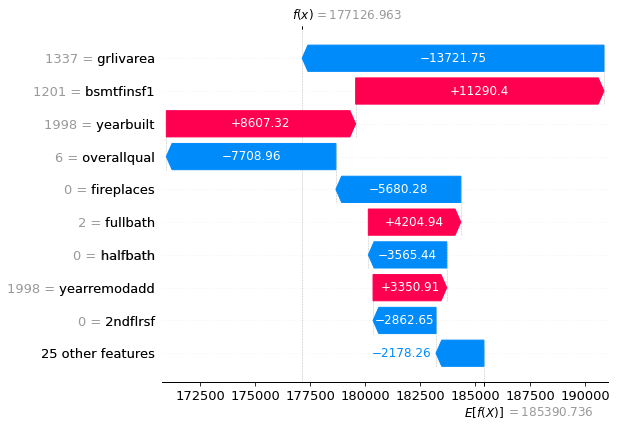

In [35]:
if local_explanations:
    shap.plots.waterfall(local_explanations[0])

The above explanation shows the features contributing to the model output from the base value (the average model output computed from the tree model) to the model output of this data point. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

Another way to visualize the same explanation is to use a force plot.

In [36]:
if local_explanations:
    shap.plots.force(local_explanations[0])

### Visualize the summary of explanations

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high overallQual value increases the house price.

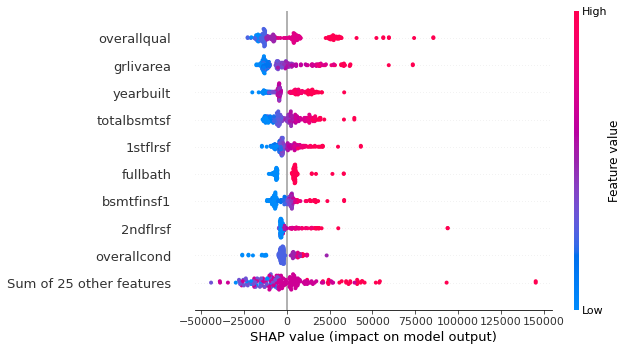

In [37]:
if local_explanations:
    shap.plots.beeswarm(local_explanations)

The generated global explanations(mean_abs or max_abs or mean_sq) could be plotted as a bar plot to understand the overall importance of features.

In the below plot the mean absolute shap values are plotted.

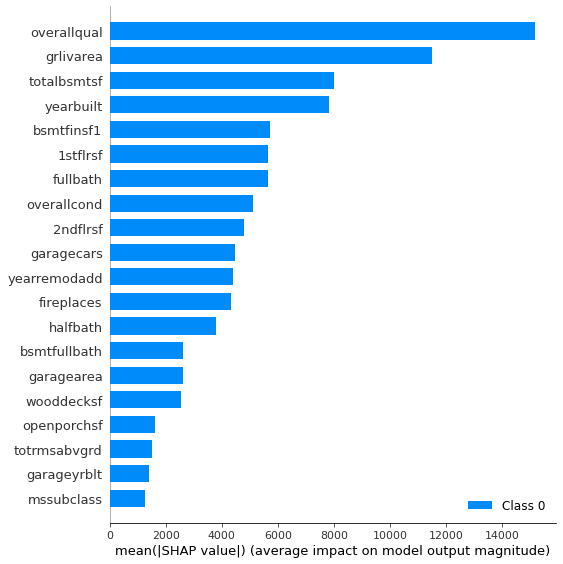

In [38]:
global_explanations = shap_explanations.get("global")
if global_explanations:
    global_explanation = global_explanations.get("mean_abs")
    shap.summary_plot(global_explanation)

In the below plot the max absolute shap values are plotted.

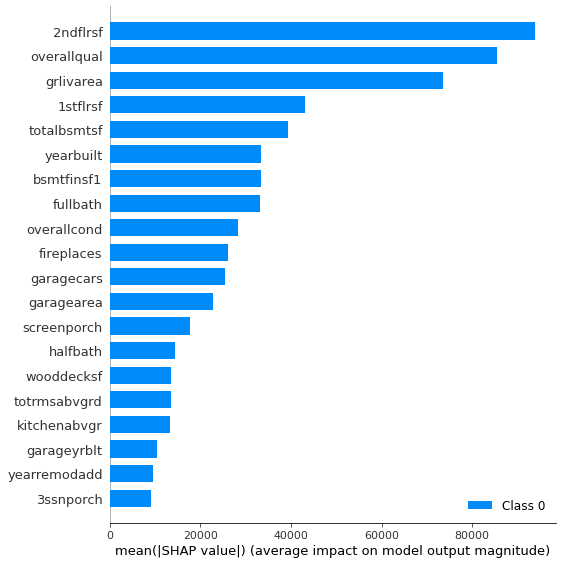

In [39]:
if global_explanations:
    global_explanation = global_explanations.get("max_abs")
    shap.summary_plot(global_explanation)

To understand how a single feature effects the output of the model, the SHAP value of that feature and the value of the feature for all the datapoints could be plotted. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in output as overallqual changes. Vertical dispersion at a single value of qverallqual represents interaction effects with other features. When all the SHAP values are passed, the feature having the higher interaction would be picked up automatically if not specified.

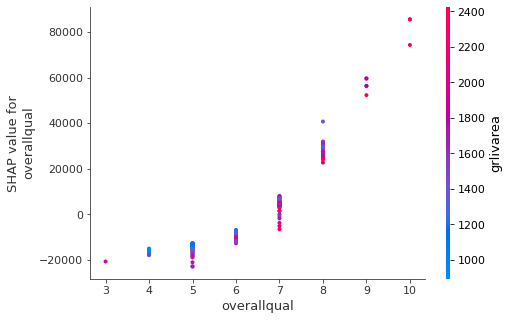

In [41]:
if local_explanations:
    shap.dependence_plot("overallqual", local_explanations.values, local_explanations.data, feature_names=local_explanations.feature_names)

**Authors**

Developed by Pratap Kishore Varma V